# Creating linearly variable color matrices

The method presented here allows to create a 3 dimensional space of color matrices whose number, colors and gradient can be modulated at will. The technique used is based on the inverse Shepard distance. The first and second blocks of functions is inspired by Christophe Hurter's work in javascript (http://recherche.enac.fr/~hurter/). The modifications made made it possible to adapt the source code to the Python language. The color matrices thus generated were then used to display automatically generated figures, with a color scale varying linearly according to a weight, called here _**`w`**_. 

# Imports

In [22]:
import math as Math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  # , LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.cm as cm

# Define functions: first bloc

This first block of functions allows to obtain the 3 dimensional space (shape = [cmap_length, n_cmaps, rgb]) containing the _**`n`**_ color matrices.

In [27]:
### Random add point
def getRandomInt(max):
    return Math.floor(Math.random() * max)


###  Random add point
def getRandomIntHex(max):
    return Math.floor(Math.random() * max).toString(16)


### Linear Interpolation
def lerp(inter, v0, v1):
    return Math.floor(inter*v0 + (1-inter)*v1)


### Distance Computation
def dist(p1, p2):
    return Math.sqrt((p2[0]-p1[0]) * (p2[0]-p1[0]) + (p2[1]-p1[1]) * (p2[1]-p1[1]))


def create_custom_colormatrix_3D(n_cmaps=100, cmap_length=256, power=5):
    '''
    Remake of Christophe Hurter's javascript implementation
    of Shepard's method on colors.

    Parameters
    ----------
    n_cmaps: int
        Amount of colormaps that will be available in the final 2D array. (all_colormatrices_list.shape[1])

    cmap_length: int
        Size of each colormap (all_colormatrices_list.shape[0]).

    power: int
        Attraction between the colors in the Shepard method. The higher, the less attraction.

    Returns
    -------
    all_colormatrices_list: list or 3D numpy array
        This array contains all the colormaps. To get color map <i>, select
        all_colormatrices_list[:, w, :].

    Note
    -----
    all_colormatrices_list.shape[2] (shape=3) represents the (r,g,b) values.

    The values in <pos> and <colors> are relative. <pos> specify where the colors
    in <colors> should be in the 2D space.
    '''

    ### Create table of position
    clientHeight = cmap_length  # n values in each color map
    clientWidth = n_cmaps  # n color maps

    pos = [
           ### Color set 1 (top of the 2D colormaps)
           {"x": 0, "y": 0},
           {"x": 0.25, "y": 0},
           {"x": 0.5, "y": 0},
           {"x": 0.75, "y": 0},
           {"x": 1, "y": 0},

           ### Colors position 2
           {"x": 0, "y": 0.1},
           {"x": 0.25, "y": 0.1},
           {"x": 0.5, "y": 0.1},
           {"x": 0.75, "y": 0.1},
           {"x": 1, "y": 0.1},

           ### Colors position 3
           {"x": 0, "y": 0.2},
           {"x": 0.25, "y": 0.2},
           {"x": 0.5, "y": 0.2},
           {"x": 0.75, "y": 0.2},
           {"x": 1, "y": 0.2},

           ### Colors position 4
           {"x": 0, "y": 0.3},
           {"x": 0.25, "y": 0.3},
           {"x": 0.5, "y": 0.3},
           {"x": 0.75, "y": 0.3},
           {"x": 1, "y": 0.3},

           ### Colors position 5
           {"x": 0, "y": 0.4},
           {"x": 0.25, "y": 0.4},
           {"x": 0.5, "y": 0.4},
           {"x": 0.75, "y": 0.4},
           {"x": 1, "y": 0.4},

           ### Color set 6
           {"x": 0, "y": 0.5},
           {"x": 0.25, "y": 0.5},
           {"x": 0.5, "y": 0.5},
           {"x": 0.75, "y": 0.5},
           {"x": 1, "y": 0.5},

           ### Color set 7
           {"x": 0, "y": 0.6},
           {"x": 0.25, "y": 0.6},
           {"x": 0.5, "y": 0.6},
           {"x": 0.75, "y": 0.6},
           {"x": 1, "y": 0.6},

           ### Color set 8
           {"x": 0, "y": 0.7},
           {"x": 0.25, "y": 0.7},
           {"x": 0.5, "y": 0.7},
           {"x": 0.75, "y": 0.7},
           {"x": 1, "y": 0.7},

           ### Color set 9
           {"x": 0, "y": 0.8},
           {"x": 0.25, "y": 0.8},
           {"x": 0.5, "y": 0.8},
           {"x": 0.75, "y": 0.8},
           {"x": 1, "y": 0.8},

           ### Color set 10
           {"x": 0, "y": 0.9},
           {"x": 0.25, "y": 0.9},
           {"x": 0.5, "y": 0.9},
           {"x": 0.75, "y": 0.9},
           {"x": 1, "y": 0.9},

           ### Color set 11 (bottom of the 2D colormaps)
           {"x": 0, "y": 1},
           {"x": 0.25, "y": 1},
           {"x": 0.5, "y": 1},
           {"x": 0.75, "y": 1},
           {"x": 1, "y": 1}
          ]

    c_ratio = 15
    colors = [
           ### Color set 1 (top of the 2D colormaps)
           {"r": 0, "g": 0, "b": 255},
           {"r": 0, "g": 255, "b": 255},
           {"r": 0, "g": 255, "b": 0},
           {"r": 255, "g": 255, "b": 0},
           {"r": 255, "g": 0, "b": 0},

           ### Color set 2
           {"r": c_ratio*1, "g": c_ratio*1, "b": 255},
           {"r": c_ratio*1, "g": 255, "b": 255},
           {"r": c_ratio*1, "g": 255, "b": c_ratio*1},
           {"r": 255, "g": 255, "b": c_ratio*1},
           {"r": 255, "g": c_ratio*1, "b": c_ratio*1},

           ### Color set 3
           {"r": c_ratio*2, "g": c_ratio*2, "b": 255},
           {"r": c_ratio*2, "g": 255, "b": 255},
           {"r": c_ratio*2, "g": 255, "b": c_ratio*2},
           {"r": 255, "g": 255, "b": c_ratio*2},
           {"r": 255, "g": c_ratio*2, "b": c_ratio*2},

           ### Color set 4
           {"r": c_ratio*3, "g": c_ratio*3, "b": 255},
           {"r": c_ratio*3, "g": 255, "b": 255},
           {"r": c_ratio*3, "g": 255, "b": c_ratio*3},
           {"r": 255, "g": 255, "b": c_ratio*3},
           {"r": 255, "g": c_ratio*3, "b": c_ratio*3},

           ### Color set 5
           {"r": c_ratio*4, "g": c_ratio*4, "b": 255},
           {"r": c_ratio*4, "g": 255, "b": 255},
           {"r": c_ratio*4, "g": 255, "b": c_ratio*4},
           {"r": 255, "g": 255, "b": c_ratio*4},
           {"r": 255, "g": c_ratio*4, "b": c_ratio*4},

           ### Color set 6 
           {"r": c_ratio*5, "g": c_ratio*5, "b": 255},
           {"r": c_ratio*5, "g": 255, "b": 255},
           {"r": c_ratio*5, "g": 255, "b": c_ratio*5},
           {"r": 255, "g": 255, "b": c_ratio*5},
           {"r": 255, "g": c_ratio*5, "b": c_ratio*5},

           ### Color set 7
           {"r": c_ratio*6, "g": c_ratio*6, "b": 255},
           {"r": c_ratio*6, "g": 255, "b": 255},
           {"r": c_ratio*6, "g": 255, "b": c_ratio*6},
           {"r": 255, "g": 255, "b": c_ratio*6},
           {"r": 255, "g": c_ratio*6, "b": c_ratio*6},

           ### Color set 8
           {"r": c_ratio*7, "g": c_ratio*7, "b": 255},
           {"r": c_ratio*7, "g": 255, "b": 255},
           {"r": c_ratio*7, "g": 255, "b": c_ratio*7},
           {"r": 255, "g": 255, "b": c_ratio*7},
           {"r": 255, "g": c_ratio*7, "b": c_ratio*7},

           ### Color set 9
           {"r": c_ratio*8, "g": c_ratio*8, "b": 255},
           {"r": c_ratio*8, "g": 255, "b": 255},
           {"r": c_ratio*8, "g": 255, "b": c_ratio*8},
           {"r": 255, "g": 255, "b": c_ratio*8},
           {"r": 255, "g": c_ratio*8, "b": c_ratio*8},

           ### Color set 10
           {"r": c_ratio*9, "g": c_ratio*9, "b": 255},
           {"r": c_ratio*9, "g": 255, "b": 255},
           {"r": c_ratio*9, "g": 255, "b": c_ratio*9},
           {"r": 255, "g": 255, "b": c_ratio*9},
           {"r": 255, "g": c_ratio*9, "b": c_ratio*9},

           ### Color set 11 (bottom of the 2D colormaps)
           {"r": 255, "g": 255, "b": 255},
           {"r": 255, "g": 255, "b": 255},
           {"r": 255, "g": 255, "b": 255},
           {"r": 255, "g": 255, "b": 255},
           {"r": 255, "g": 255, "b": 255}
    ]

    n_colors = len(pos)  # len(pos)
    all_colormatrices_list = []
    for y in range(0, clientHeight):
        all_colormatrices_list.append([])
        for x in range(0, clientWidth):
            ### Compute the distances
            p = (x/clientWidth, y/clientHeight)

            ### Compute the inverse distance weighting (IDW)
            d = list(np.repeat(0, len(pos)))

            colShepard = {"r": 0, "g": 0, "b": 0}

            for i in range(0, n_colors):
                d[i] = Math.pow(dist(p, [pos[i]["x"], pos[i]["y"]]), power)

            sumDist = 0
            for i in range(0, n_colors):
                if d[i] != 0:
                    sumDist += 1/d[i]

            ### Compute the interpolation
            for i in range(0, n_colors):
                if (d[i] == 0):
                    colShepard["r"] = colors[i]["r"]
                    colShepard["g"] = colors[i]["g"]
                    colShepard["b"] = colors[i]["b"]
                else:
                    colShepard["r"] += 1/d[i] * colors[i]["r"] / (sumDist)
                    colShepard["g"] += 1/d[i] * colors[i]["g"] / (sumDist)
                    colShepard["b"] += 1/d[i] * colors[i]["b"] / (sumDist)

            ### color hack toward white
            inter = {"r": 0, "g": 0, "b": 0}
            inter["r"] = lerp(Math.pow(y/clientHeight, 1), 255, colShepard["r"])
            inter["g"] = lerp(Math.pow(y/clientHeight, 1), 255, colShepard["g"])
            inter["b"] = lerp(Math.pow(y/clientHeight, 1), 255, colShepard["b"])

            if inter["r"] > 255:
                print(f"[x = {x}/{clientWidth} y = {y}/{clientHeight}] \nr: {inter['r']} value is not valid, was set to 255.\n")
                inter["r"] = 255
            if inter["g"] > 255:
                print(f"[x = {x}/{clientWidth} y = {y}/{clientHeight}] \ng: {inter['g']} value is not valid, was set to 255.\n")
                inter["g"] = 255
            if inter["b"] > 255:
                print(f"[x = {x}/{clientWidth} y = {y}/{clientHeight}] \nb: {inter['b']} value is not valid, was set to 255.\n")
                inter["b"] = 255

            #col = "#" + decimalToHex(colShepard["r"]) + decimalToHex(colShepard["g"]) + decimalToHex(colShepard["b"]) + "ff";
            col = [inter["r"]/255, inter["g"]/255, inter["b"]/255]
            all_colormatrices_list[-1].append(col)

    all_colormatrices_list = np.array(all_colormatrices_list)
    print(f"There are {all_colormatrices_list.shape[1]} color matrices of shape ({all_colormatrices_list.shape[0]},{all_colormatrices_list.shape[2]})")

    return(all_colormatrices_list)

# Define functions: second bloc

This second block of functions allows to generate a customizable color matrix in 2 dimensions (shape = [cmap_length, rgb]). This color matrix can be concatenated with an _**`i`**_ color matrix of the 3 dimensional space defined previously. The assembly of these color matrices allows to create the delineation and the "transparency" around the high intensity pixels of the image.

In [28]:
def create_custom_colormatrix_2D(cmap_length=600):
    '''
    Remake of Christophe Hurter's javascript implementation
    of the interpolation between <n> colors (two or more).

    Parameters
    ----------
    cmap_length: int
        Size of the colormap (all_colormatrices_list.shape[0]).

    Returns
    -------
    colormatrix: list or 2D numpy array
        This is the color matrix that can be used to created a color map.

    Note
    -----
    all_colormatrices_list.shape[1] (shape=3) represents the (r,g,b) values.
    '''

    clientWidth = cmap_length

    ### Gradient 1D

    ###Defines colors
    color1 = {"r": 220, "g": 220, "b": 220}
    color2 = {"r": 255, "g": 255, "b": 255}

    colormatrix = []

    ### Manually set the first 0-20 values (from mid-light gray gray to black)
    decrease_step = 10
    decrease_i = 10
    rgb_start = 200
    for i in range(20):
        decrease_i = decrease_step * i
        colormatrix.append(np.array([rgb_start-decrease_i,
                                    rgb_start-decrease_i,
                                    rgb_start-decrease_i,
                                    1]) / 255)
        colormatrix[-1][-1] = 1  # Force alpha to 1

    ### Manually set the 20-40 values (from black to mid-light gray)
    increase_step = 10
    increase_i = 10
    rgb_start = 0
    i = 0
    for j in range(20, 40):
        increase_i = increase_step * i
        colormatrix.append(np.array([rgb_start+increase_i,
                                    rgb_start+increase_i,
                                    rgb_start+increase_i,
                                    1]) / 255)
        colormatrix[-1][-1] = 1  # Force alpha to 1
        i += 1

    ### Use interpolation to create a colormap between light gray and high-light gray
    for x in range(0, clientWidth):
        t = x/clientWidth
        colormatrix.append([lerp(t, color2["r"], color1["r"])/255,
                            lerp(t, color2["g"], color1["g"])/255,
                            lerp(t, color2["b"], color1["b"])/255,
                            1])

    colormatrix = np.array(colormatrix)
    return(colormatrix)

# Define functions: third bloc

This third block of functions allows (1) to create a color map usable by matplotlib from the color matrices obtained using the previous functions; (2) to obtain the color bar of all the colors available in the 3-dimensional space of the color maps; (3) to generate an image that we will use to illustrate the variation of the available colors on concreate examples.

In [29]:
def create_cmap(cmatrix_dict, combine_two_cmaps=True):
    '''
    Create a unique color matrix and color map using two
    concatenated 2D (shape = [cmap_length, rgb]) color maps.

    Parameters
    ----------
    r: list of floats:
        Red value, between 0 and 1
    g: list of floats:
        Green value, between 0 and 1
    b: list of floats
        Blue value, between 0 and 1

    Returns:
    color_matrix: numpy 2D array
        Contains all the rgb values for a given colormap
    color_map: matplotlib object
        The color_matrix transformed into an object that matplotlib can use on figures
    '''

    ### Init rgba matrix
    if combine_two_cmaps:
        cmatrix_2D = create_custom_colormatrix_2D(cmap_length=600)
        cmatrix_2D_length = len(cmatrix_2D)
        color_matrix = np.empty([len(cmatrix_dict["r"])+cmatrix_2D_length, 4])
        color_matrix.fill(0)
        color_matrix[0:cmatrix_2D_length] = cmatrix_2D

        ### Fill our empty matrix with our r,g,b values
        color_matrix[cmatrix_2D_length:, 0] = cmatrix_dict["r"]
        color_matrix[cmatrix_2D_length:, 1] = cmatrix_dict["g"]
        color_matrix[cmatrix_2D_length:, 2] = cmatrix_dict["b"]
        color_matrix[cmatrix_2D_length:, 3] = np.repeat(1, len(cmatrix_dict["b"]))  # alpha channel
    else:
        color_matrix = np.empty([len(cmatrix_dict["r"]), 4])
        color_matrix.fill(0)

        ### Fill our empty matrix with our r,g,b values
        color_matrix[:, 0] = cmatrix_dict["r"]
        color_matrix[:, 1] = cmatrix_dict["g"]
        color_matrix[:, 2] = cmatrix_dict["b"]
        color_matrix[:, 3] = np.repeat(1, len(cmatrix_dict["b"]))  # alpha channel

    color_map = ListedColormap(color_matrix)

    return(color_matrix, color_map)


def get_all_cmaps(all_colormatrices_list):
    '''
    Given a list of 3D colormatrices (cmap_length, n_cmaps, rgba), extract the top row (highest values/colors)
    and store them to a 2D list (cmap_length, rgba) to use these colors as a colorbar with all the possible colors
    in the 3D list/array.
    '''
    rgb_max_all_cmaps = []
    for i in range(all_colormatrices_list[1, :, 1].shape[0]):
        rgb_max_all_cmaps.append(all_colormatrices_list[1, i, :])
    all_colormaps = ListedColormap(rgb_max_all_cmaps)

    return(all_colormaps)

def create_image():
    '''
    Create some random image on which we will apply the colormap.
    Any other image could replace this one.
    '''

    dx, dy = 0.015, 0.05
    x = np.arange(-4.0, 4.0, dx)
    y = np.arange(-4.0, 4.0, dy)
    X, Y = np.meshgrid(x, y)

    def z_fun(x, y):
        return (1 - x / 2 + x**5 + y**6) * np.exp(-(x**2 + y**2))

    Z2 = z_fun(X, Y)
    return(Z2)


In [30]:

print("\nStarting process. This operation might take a few seconds.\n")
all_colormatrices_list = create_custom_colormatrix_3D(n_cmaps=1000, cmap_length=600)
print("Done")



Starting process. This operation might take a few seconds.

[x = 0/1000 y = 0/600] 
b: 509 value is not valid, was set to 255.

[x = 250/1000 y = 0/600] 
g: 505 value is not valid, was set to 255.

[x = 250/1000 y = 0/600] 
b: 502 value is not valid, was set to 255.

[x = 500/1000 y = 0/600] 
g: 507 value is not valid, was set to 255.

[x = 750/1000 y = 0/600] 
r: 504 value is not valid, was set to 255.

[x = 750/1000 y = 0/600] 
g: 502 value is not valid, was set to 255.

[x = 0/1000 y = 60/600] 
b: 372 value is not valid, was set to 255.

[x = 250/1000 y = 60/600] 
g: 371 value is not valid, was set to 255.

[x = 250/1000 y = 60/600] 
b: 370 value is not valid, was set to 255.

[x = 500/1000 y = 60/600] 
g: 372 value is not valid, was set to 255.

[x = 750/1000 y = 60/600] 
r: 371 value is not valid, was set to 255.

[x = 750/1000 y = 60/600] 
g: 370 value is not valid, was set to 255.

[x = 0/1000 y = 120/600] 
b: 357 value is not valid, was set to 255.

[x = 250/1000 y = 120/600] 

# Save the 3D color matrix to a .npy file

This operation is not necessary here, but it can be usefull if one wants to use the color matrix multiple times and in different conditions, so he does not have to calculate the color matrix multiple times.

Write array to a file as text or binary (default). Data is always written in ‘C’ order, independent of the order of a. The data produced by this method can be recovered using the function fromfile().

In [6]:
if False:
    array_shape = np.shape(np.array(all_colormatrices_list))
    path = r"/Users/gardy/Documents/GardyL/Halyzia/Halyzia_v2/halyzia/static/color_matrix_shape-{}-{}-{}.npy".format(array_shape[0], array_shape[1], array_shape[2])
    np.array(all_colormatrices_list).tofile(path)
    

# Load the .npy file

Construct an array from data in a text or binary file. A highly efficient way of reading binary data with a known data-type, as well as parsing simply formatted text files. Data written using the tofile method can be read using this function.

In [7]:
if False:
    data_shape = path.split(".")[0].split("_")[-1]
    data_shape = (int(data_shape.split("-")[1]), int(data_shape.split("-")[2]), int(data_shape.split("-")[3]))
    all_colormatrices_list = np.fromfile(path)
    all_colormatrices_list = all_colormatrices_list.reshape(data_shape)
    print(all_colormatrices_list.shape)
    

# Quick view of all the available color maps

[]

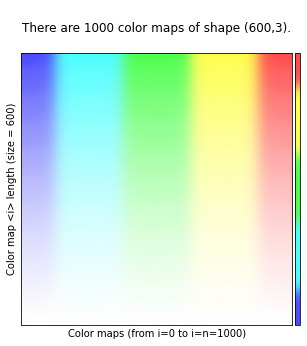

In [8]:
### Create colorbar/map
all_colormaps = get_all_cmaps(all_colormatrices_list)

### Plot color matrices list
f, ax = plt.subplots(figsize= (5,5))

img = ax.imshow(all_colormatrices_list, cmap =all_colormaps, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")
ax.set_yticks([])
ax.set_xticks([])
ax.set_title(f"\nThere are {all_colormatrices_list.shape[1]} color maps of shape ({all_colormatrices_list.shape[0]},{all_colormatrices_list.shape[2]}).\n")
ax.set_xlabel(f"Color maps (from i=0 to i=n={all_colormatrices_list.shape[1]})")
ax.set_ylabel(f"Color map <i> length (size = {all_colormatrices_list.shape[0]})")

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")
cax.set_yticks([])
cax.set_xticks([]) 

# Application example 1

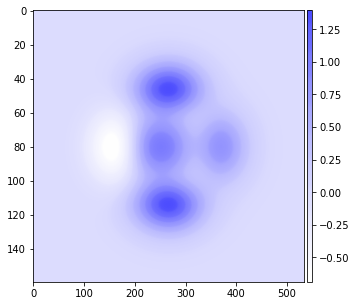

In [9]:
color_map_i = 1
color_map = ListedColormap(all_colormatrices_list[:,color_map_i,:][::-1])

#- Create image
Z2 = create_image()
f, ax = plt.subplots(figsize= (5,5))
img = ax.imshow(Z2, cmap =color_map, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")

# Application example 2

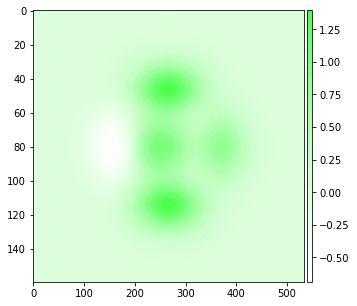

In [10]:
color_map_i = int(all_colormatrices_list.shape[1]/2)
color_map = ListedColormap(all_colormatrices_list[:,color_map_i,:][::-1])

#- Create image
Z2 = create_image()
f, ax = plt.subplots(figsize= (5,5))
img = ax.imshow(Z2, cmap =color_map, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")

# Application example 3

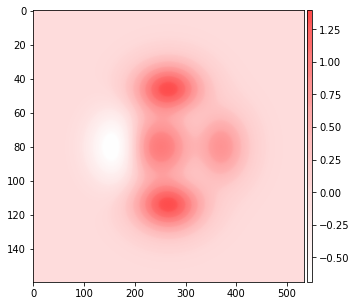

In [11]:
color_map_i = all_colormatrices_list.shape[1]-1
color_map = ListedColormap(all_colormatrices_list[:,color_map_i,:][::-1])

#- Create image
Z2 = create_image()
f, ax = plt.subplots(figsize= (5,5))
img = ax.imshow(Z2, cmap =color_map, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")

# Application multiple-example 4

Apply a linear variation of _**`w`**_ to pick a color map in the 3D color matrix.

In [12]:
combine_two_cmaps = False

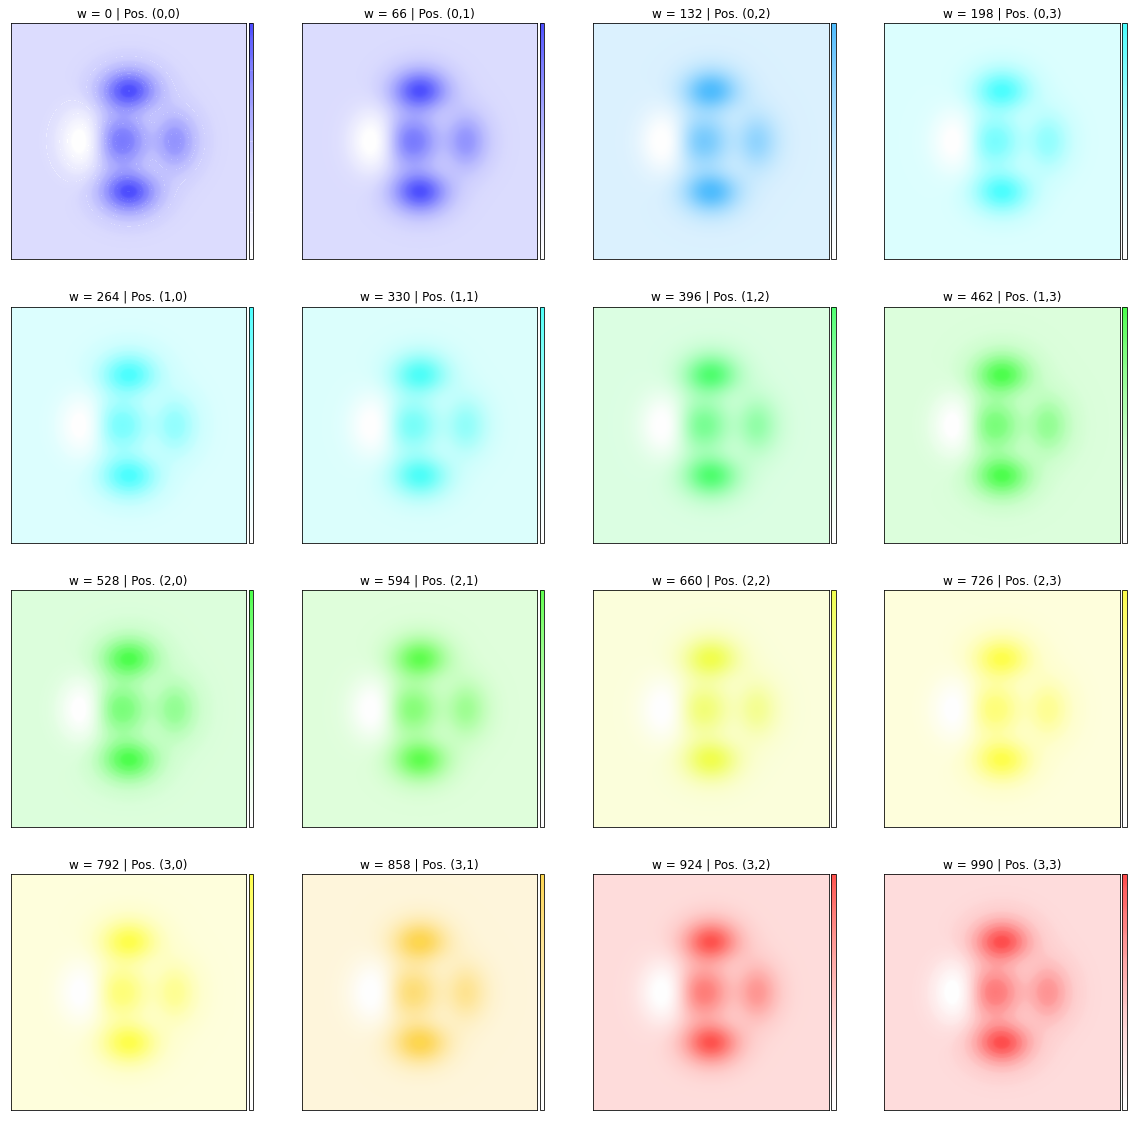

In [13]:
### Let us create some image (any other could be used).
Z2 = create_image()

### Now create a color map, using the w value you want 0 = white-red, 765 = white-purple.
f, ax = plt.subplots(4,4, figsize= (20,20))

col = 0
for i, w in enumerate(np.arange(0,all_colormatrices_list.shape[1],int(all_colormatrices_list.shape[1]/15))):
    
    row = int(i/4)
    if row > 3:
        break

    #- Create image
    cmatrix_dict = {"r": all_colormatrices_list[:, w, :][::-1][:, 0],
                    "g": all_colormatrices_list[:, w, :][::-1][:, 1],
                    "b": all_colormatrices_list[:, w, :][::-1][:, 2]}
    cmap, color_map = create_cmap(cmatrix_dict, combine_two_cmaps)
    
    img = ax[row,col].imshow(Z2, cmap =color_map, alpha=0.7, interpolation ='bilinear',aspect = "auto")
    ax[row,col].set_title("w = {} | Pos. ({},{})".format(w,row,col))    
    ax[row,col].set_yticks([])
    ax[row,col].set_xticks([])
    
    #- Create colorbar
    aspect = 20
    pad_fraction = 0.5
    divider = make_axes_locatable(ax[row,col])
    height = axes_size.AxesX(ax[row,col], aspect=2/100)
    pad = axes_size.Fraction(0.5, height)
    cax = divider.append_axes("right", size=height, pad=pad)
    cax.tick_params(axis='both', which='major')
    plt.colorbar(img, cax=cax, orientation="vertical")    
    cax.set_yticks([])
    cax.set_xticks([]) 

    col +=1
    if col == 4:
        col = 0  
        

    

# Combining two color maps

One given 2D color map (cmap_length, rgb), with one other color map coming from our 3D color matrix (cmap_length, n_cmaps, rgb).

Text(0.5, 1.0, '3D (n_cmaps, cmap_length, rgb) color map list (ex: pick cmap <i> on x-axis)')

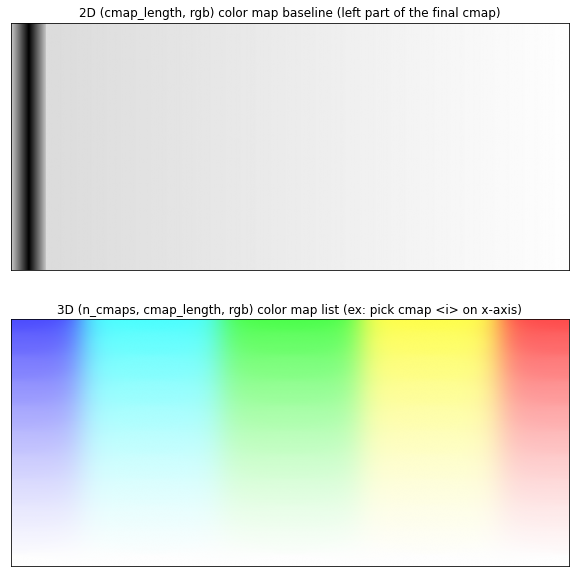

In [14]:
colormatrix = create_custom_colormatrix_2D()

### Duplicate the 2D color matrix to plot it
img = []
for i in range(10):
    img.append(colormatrix)
img=np.array(img)
cmap = ListedColormap(colormatrix)

### Create figure
f, ax = plt.subplots(nrows=2, figsize= (10,10))

### Plot 2D color matrix
ax[0].imshow(img,aspect="auto",cmap=cmap)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_title("2D (cmap_length, rgb) color map baseline (left part of the final cmap)")

### Plot 3D color matrix
ax[1].imshow(all_colormatrices_list, cmap =all_colormaps, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title("3D (n_cmaps, cmap_length, rgb) color map list (ex: pick cmap <i> on x-axis)")

In [15]:
combine_two_cmaps = True

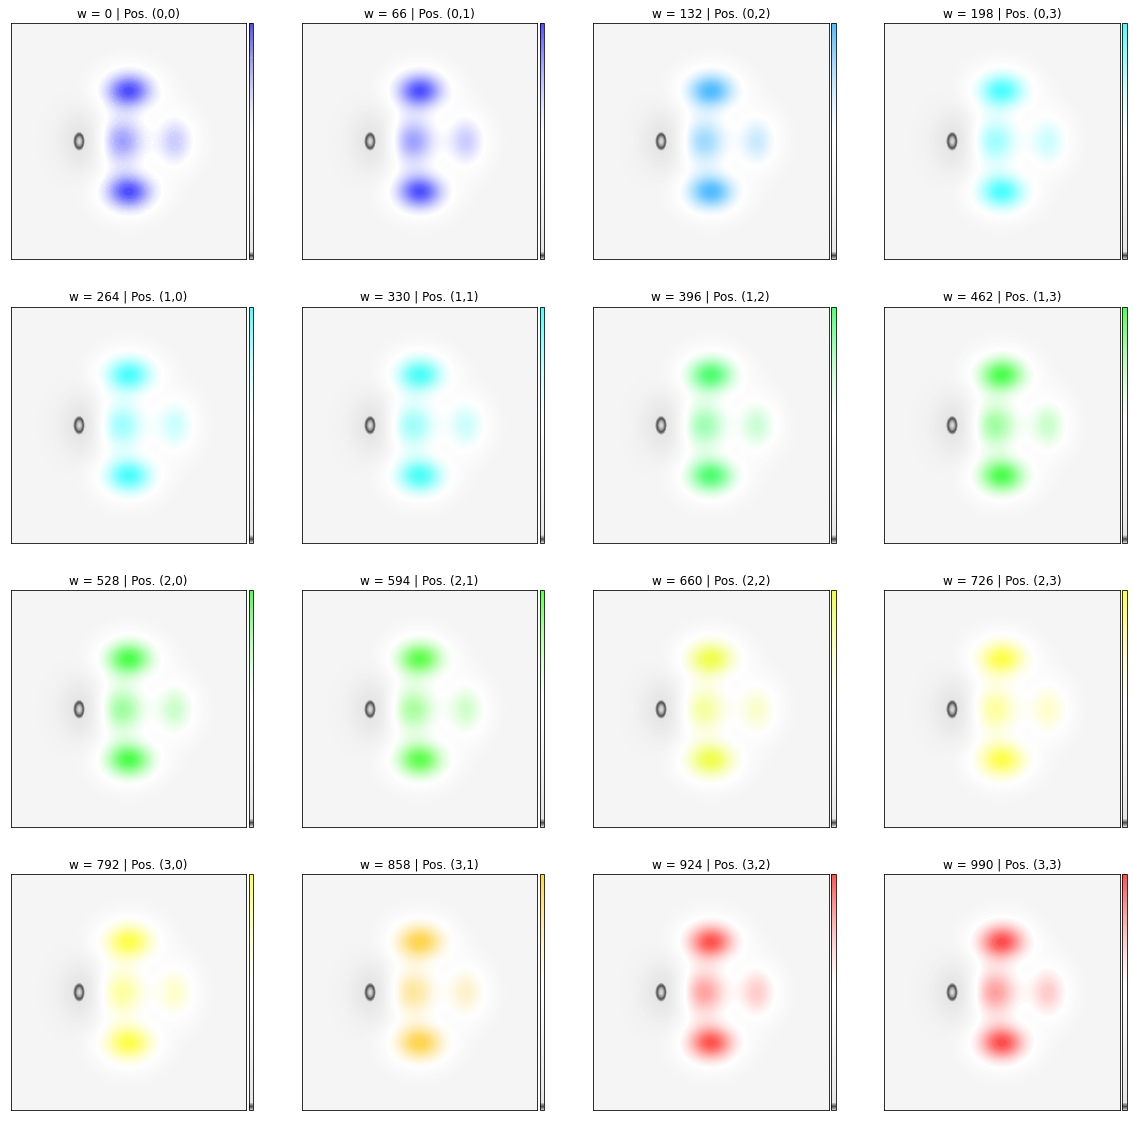

In [16]:
### Let us create some image (any other could be used).
Z2 = create_image()

### Now create a color map, using the w value you want 0 = white-red, 765 = white-purple.
f, ax = plt.subplots(4,4, figsize= (20,20))

col = 0
for i, w in enumerate(np.arange(0,all_colormatrices_list.shape[1],int(all_colormatrices_list.shape[1]/15))):
    
    row = int(i/4)
    if row > 3:
        break

    #- Create image
    cmatrix_dict = {"r": all_colormatrices_list[:, w, :][::-1][:, 0],
                    "g": all_colormatrices_list[:, w, :][::-1][:, 1],
                    "b": all_colormatrices_list[:, w, :][::-1][:, 2]}
    cmap, color_map = create_cmap(cmatrix_dict, combine_two_cmaps)
    
    img = ax[row,col].imshow(Z2, cmap =color_map, alpha=0.7, interpolation ='bilinear',aspect = "auto")
    ax[row,col].set_title("w = {} | Pos. ({},{})".format(w,row,col))    
    ax[row,col].set_yticks([])
    ax[row,col].set_xticks([])
    
    #- Create colorbar
    aspect = 20
    pad_fraction = 0.5
    divider = make_axes_locatable(ax[row,col])
    height = axes_size.AxesX(ax[row,col], aspect=2/100)
    pad = axes_size.Fraction(0.5, height)
    cax = divider.append_axes("right", size=height, pad=pad)
    cax.tick_params(axis='both', which='major')
    plt.colorbar(img, cax=cax, orientation="vertical")    
    cax.set_yticks([])
    cax.set_xticks([]) 

    col +=1
    if col == 4:
        col = 0  
        